In [2]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [4]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [5]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [6]:
tf.keras.backend.clear_session()

In [7]:
subject = 'Sergipe - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [8]:
data = pd.read_csv('2003_raw_Sergipe_input.csv')
pd.set_option('display.max_columns', None)
data = data.replace(-1.0, np.nan)
data

,data,Sergipe - PIB - Per Capita,Sergipe - PIB - Preços de Mercado,Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - População,Sergipe - INCC (%),Sergipe - IPCA - Variação mensal durante o Plano Real (%),Sergipe - IGP-DI,Sergipe - Taxa Selic (%),Sergipe - IDH - Longevidade,Sergipe - IDH - Renda,Sergipe - IDH - Educação,Sergipe - NFSP - Fluxo Mensal (Milhões de reais),Sergipe - Estoque liquido de capital fixo - (R$),Sergipe - Desemprego,Sergipe - Produção de Cimento (t),Sergipe - Valor,Sergipe - Consumo de Cimento (t)
0,2003-01-01,1.467602e+06,7.725253e+05,0.795000,1.068521e+06,1846039.0,1.70,12.53,2.70,0.082293,0.678,0.596,0.343,3.46,6.098524e+06,10.988206,NaN,0.31,23616.0
1,2003-02-01,1.467602e+06,7.725253e+05,0.795000,1.068521e+06,1846039.0,1.51,2.25,2.17,0.088771,0.678,0.596,0.343,3.59,6.172460e+06,10.988206,NaN,0.34,21357.0
2,2003-03-01,1.467602e+06,7.725253e+05,0.795000,1.068521e+06,1846039.0,1.39,3.86,1.59,0.090733,0.678,0.596,0.343,3.84,6.172460e+06,10.988206,38102.0,0.34,20059.0
3,2003-04-01,1.467602e+06,7.725253e+05,0.795000,1.068521e+06,1846039.0,1.38,5.13,1.66,0.092749,0.678,0.596,0.343,3.95,6.172460e+06,10.988206,147437.0,0.35,19920.0
4,2003-05-01,1.467602e+06,7.725253e+05,0.795000,1.068521e+06,1846039.0,0.90,6.15,0.41,0.092758,0.678,0.596,0.343,4.06,6.172460e+06,10.988206,67985.0,0.35,19962.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2019-08-01,1.841252e+06,3.106822e+06,0.808166,1.091268e+06,2278308.0,0.58,2.42,-0.01,0.024620,0.800,0.680,0.640,0.69,7.827728e+06,12.300000,69743.0,0.43,29860.0
200,2019-09-01,1.841252e+06,3.106822e+06,0.808166,1.091268e+06,2278308.0,0.42,2.54,-0.51,0.022751,0.800,0.680,0.640,0.62,7.827728e+06,12.000000,NaN,0.43,39045.0
201,2019-10-01,1.841252e+06,3.106822e+06,0.808166,1.091268e+06,2278308.0,0.46,2.49,0.50,0.022035,0.800,0.680,0.640,0.59,7.827728e+06,11.900000,104780.0,0.42,45213.0
202,2019-11-01,1.841252e+06,3.106822e+06,0.808166,1.091268e+06,2278308.0,0.18,2.60,0.55,0.020790,0.800,0.680,0.640,0.57,7.827728e+06,11.700000,NaN,0.42,42237.0


In [9]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data = target_data/1000
target_data

0      18.244
1      18.161
2      23.259
3      19.137
4      15.066
        ...  
199       NaN
200       NaN
201       NaN
202       NaN
203       NaN
Name: Sergipe - Consumo de Cimento (t), Length: 204, dtype: float64

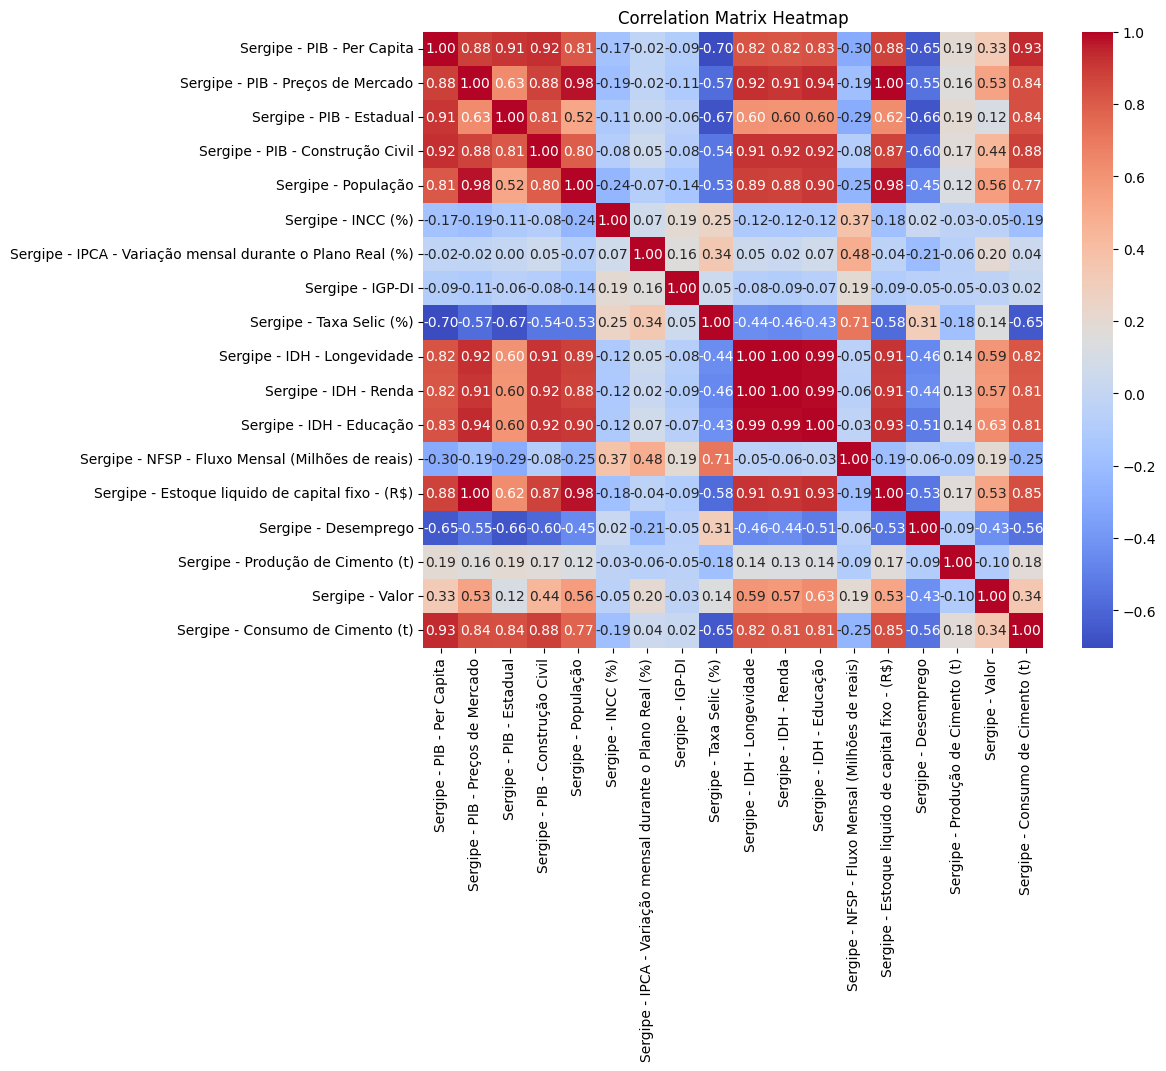

In [10]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [11]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data = input_data.fillna(0.0)
input_data

,Sergipe - PIB - Per Capita,Sergipe - PIB - Preços de Mercado,Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - População,Sergipe - INCC (%),Sergipe - IPCA - Variação mensal durante o Plano Real (%),Sergipe - IGP-DI,Sergipe - Taxa Selic (%),Sergipe - IDH - Longevidade,Sergipe - IDH - Renda,Sergipe - IDH - Educação,Sergipe - NFSP - Fluxo Mensal (Milhões de reais),Sergipe - Estoque liquido de capital fixo - (R$),Sergipe - Desemprego,Sergipe - Produção de Cimento (t),Sergipe - Valor
0,-1.546546,-1.417605,-1.145491,-0.786121,-1.593044,1.998868,4.052332,3.466715,2.303195,-0.931678,-0.929829,-0.923584,3.108599,-1.539424,0.526169,0.000000,-1.168813
1,-1.546546,-1.417605,-1.145491,-0.786121,-1.593044,1.647487,-0.596188,2.630940,2.745235,-0.931678,-0.929829,-0.923584,3.275709,-1.411460,0.526169,0.000000,-0.389200
2,-1.546546,-1.417605,-1.145491,-0.786121,-1.593044,1.425561,0.131839,1.716318,2.879123,-0.931678,-0.929829,-0.923584,3.597074,-1.411460,0.526169,-0.960232,-0.389200
3,-1.546546,-1.417605,-1.145491,-0.786121,-1.593044,1.407068,0.706121,1.826703,3.016721,-0.931678,-0.929829,-0.923584,3.738475,-1.411460,0.526169,-0.015068,-0.129329
4,-1.546546,-1.417605,-1.145491,-0.786121,-1.593044,0.519367,1.167355,-0.144465,3.017322,-0.931678,-0.929829,-0.923584,3.879875,-1.411460,0.526169,-0.701904,-0.129329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.134755,1.441939,-0.917177,0.616517,1.658870,-0.590259,-0.966985,-1.264088,-0.729479,1.323574,1.453915,1.250297,-0.374997,1.441346,0.987010,-0.240011,0.442386
176,0.134755,1.441939,-0.917177,0.616517,1.658870,-0.479297,-0.881068,-0.412544,-0.941281,1.323574,1.453915,1.250297,-0.439270,1.441346,0.987010,-1.150328,0.442386
177,0.134755,1.441939,-0.917177,0.616517,1.658870,-1.034110,-0.808718,0.186692,-1.140710,1.323574,1.453915,1.250297,-0.503543,1.441346,0.987010,-0.228704,0.650283
178,0.134755,1.441939,-0.917177,0.616517,1.658870,-0.571766,-0.614276,-0.633314,-1.226481,1.323574,1.453915,1.250297,-0.503543,1.441346,1.037552,0.000000,0.650283


In [12]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Sergipe - PIB - Per Capita,Sergipe - PIB - Preços de Mercado,Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - População,Sergipe - INCC (%),Sergipe - IPCA - Variação mensal durante o Plano Real (%),Sergipe - IGP-DI,Sergipe - Taxa Selic (%),Sergipe - IDH - Longevidade,Sergipe - IDH - Renda,Sergipe - IDH - Educação,Sergipe - NFSP - Fluxo Mensal (Milhões de reais),Sergipe - Estoque liquido de capital fixo - (R$),Sergipe - Desemprego,Sergipe - Produção de Cimento (t),Sergipe - Valor
0,-1.546546,-1.417605,-1.145491,-0.786121,-1.593044,1.998868,4.052332,3.466715,2.303195,-0.931678,-0.929829,-0.923584,3.108599,-1.539424,0.526169,0.000000,-1.168813
1,-1.546546,-1.417605,-1.145491,-0.786121,-1.593044,1.647487,-0.596188,2.630940,2.745235,-0.931678,-0.929829,-0.923584,3.275709,-1.411460,0.526169,0.000000,-0.389200
2,-1.546546,-1.417605,-1.145491,-0.786121,-1.593044,1.425561,0.131839,1.716318,2.879123,-0.931678,-0.929829,-0.923584,3.597074,-1.411460,0.526169,-0.960232,-0.389200
3,-1.546546,-1.417605,-1.145491,-0.786121,-1.593044,1.407068,0.706121,1.826703,3.016721,-0.931678,-0.929829,-0.923584,3.738475,-1.411460,0.526169,-0.015068,-0.129329
4,-1.546546,-1.417605,-1.145491,-0.786121,-1.593044,0.519367,1.167355,-0.144465,3.017322,-0.931678,-0.929829,-0.923584,3.879875,-1.411460,0.526169,-0.701904,-0.129329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.748786,1.414632,0.069591,0.741012,1.481903,-0.238878,0.629248,-1.406012,0.272188,1.138717,0.997453,1.326042,0.794771,1.416222,-0.529257,0.000000,1.299960
164,0.748786,1.414632,0.069591,0.741012,1.481903,-0.608753,0.837256,-0.112926,0.272188,1.138717,0.997453,1.326042,0.730498,1.416222,-0.478715,0.000000,0.650283
165,0.748786,1.414632,0.069591,0.741012,1.481903,-0.534778,0.877953,-0.743700,0.272188,1.138717,0.997453,1.326042,0.743353,1.416222,-0.428173,0.000000,0.647684
166,0.748786,1.414632,0.069591,0.741012,1.481903,-0.756703,1.000045,-0.586006,0.248413,1.138717,0.997453,1.326042,0.614807,1.416222,-0.428173,0.000000,0.650283


In [13]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      18.244
1      18.161
2      23.259
3      19.137
4      15.066
        ...  
163    31.132
164    30.195
165    31.537
166    30.748
167    30.734
Name: Sergipe - Consumo de Cimento (t), Length: 168, dtype: float64

In [14]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [15]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 17)

In [16]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Sergipe - PIB - Per Capita,Sergipe - PIB - Preços de Mercado,Sergipe - PIB - Estadual,Sergipe - PIB - Construção Civil,Sergipe - População,Sergipe - INCC (%),Sergipe - IPCA - Variação mensal durante o Plano Real (%),Sergipe - IGP-DI,Sergipe - Taxa Selic (%),Sergipe - IDH - Longevidade,Sergipe - IDH - Renda,Sergipe - IDH - Educação,Sergipe - NFSP - Fluxo Mensal (Milhões de reais),Sergipe - Estoque liquido de capital fixo - (R$),Sergipe - Desemprego,Sergipe - Produção de Cimento (t),Sergipe - Valor
132,1.310254,1.089205,1.153079,1.368654,1.115642,-0.960135,1.058830,0.297077,-0.755853,0.953860,0.997453,1.023062,-0.285015,0.834026,-1.337933,-0.870275,0.057778
133,1.310254,1.089205,1.153079,1.368654,1.115642,0.482379,-1.364912,-0.160234,-0.688658,0.953860,0.997453,1.023062,-0.349288,1.129318,-1.085222,0.000000,0.468374
134,1.310254,1.089205,1.153079,1.368654,1.115642,-0.534778,-1.052901,0.549386,-0.626634,0.953860,0.997453,1.023062,-0.374997,1.129318,-0.933595,0.000000,0.962128
135,1.310254,1.089205,1.153079,1.368654,1.115642,-0.627247,-0.627842,1.542855,-0.571481,0.953860,0.997453,1.023062,-0.259306,1.129318,-1.034679,0.000000,0.962128
136,1.310254,1.089205,1.153079,1.368654,1.115642,0.482379,-0.320352,-0.081387,-0.516512,0.953860,0.997453,1.023062,-0.053632,1.129318,-1.135764,0.000000,1.170025
137,1.310254,1.089205,1.153079,1.368654,1.115642,2.646150,-0.107822,-1.500628,-0.510405,0.953860,0.997453,1.023062,0.023495,1.129318,-1.236848,-0.738738,1.170025
138,1.310254,1.089205,1.153079,1.368654,1.115642,0.075516,0.082098,-1.784477,-0.510405,0.953860,0.997453,1.023062,-0.002214,1.129318,-1.287391,0.000000,1.170025
139,1.310254,1.089205,1.153079,1.368654,1.115642,0.241960,0.086620,-1.658322,-0.510405,0.953860,0.997453,1.023062,-0.143614,1.129318,-1.388475,0.000000,1.170025
140,1.310254,1.089205,1.153079,1.368654,1.115642,-0.997122,0.204189,-0.696392,-0.510054,0.953860,0.997453,1.023062,-0.182178,1.129318,-1.489560,0.000000,1.668977
141,1.310254,1.089205,1.153079,1.368654,1.115642,-0.867666,0.470982,-0.759469,-0.510405,0.953860,0.997453,1.023062,-0.105051,1.129318,-1.590644,0.142429,1.960032


In [17]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 17)

In [18]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(144, activation='tanh',
                             return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(36, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [39]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [40]:
def predictor(model, test_input, test_target, start_target):
    
    predictions = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        if (prediction[0][0] < 0.0):
            return None, None
        predictions.append(prediction[0][0])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    return df_results, predictions

In [41]:
def statistical_validator(train_input, train_target, test_input, test_target, start_target):
    
    pd.set_option('display.max_columns', None)
    predictions_list = []
    error_percent = []
    
    i = 0
    while i < 10:
        winner_seed = get_a_good_seed(train_input, train_target, test_input, test_target)
        trained_model, history = lstm_model(train_input, 
                                            train_target, 
                                            want_verbose=0, 
                                            seed=winner_seed)
        df_results, predictions = predictor(trained_model, 
                                            test_input, 
                                            test_target, 
                                            start_index)
        if predictions is not None:
            display(df_results.T)
            predictions_list.append(predictions)
            i += 1
        
    predictions_means = np.mean(predictions_list, axis=0)
    results_data = []
   
    for j in range(12):
        target = test_target[start_target + j]
        error = np.abs(predictions_means[j] - target)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                            predictions_means[j], 
                            target, 
                            error])
    display("FINAL___________________________________________________________________")
    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    display(df_results.T)
        
    mae_mean = np.mean(predictions_means)
    mape_mean = np.mean(error_percent) 

    return mae_mean, mape_mean

In [42]:
mae, mape = statistical_validator(reshaped_train, 
                                  reshaped_target, 
                                  reshaped_test, 
                                  reshaped_test_target, 
                                  start_index)

[2331051911, 1318692063, 261005402, 365378045, 4034966867, 1272399037, 527606077, 3788063032, 2199697852, 1252764581]


Step: 0 ___________________________________________
val_loss: 61.506019592285156
winner_seed: 2331051911


Step: 1 ___________________________________________
val_loss: 25.21792221069336
winner_seed: 1318692063


Step: 2 ___________________________________________
val_loss: 27.53133201599121


Step: 3 ___________________________________________
val_loss: 27.6938419342041


Step: 4 ___________________________________________
val_loss: 16.571636199951172
winner_seed: 4034966867


Step: 5 ___________________________________________
val_loss: 41.89955520629883


Step: 6 ___________________________________________
val_loss: 17.735044479370117


Step: 7 ___________________________________________
val_loss: 15.6889066696167
winner_seed: 3788063032


Step: 8 ___________________________________________
val_loss: 27.479839324951172


Step: 9 ____________________________________

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,32.389462,33.33968,30.979319,31.073404,28.965858,28.277576,30.67688,30.631672,31.592878,34.851883,35.718536,35.799515
Target,36.567,30.849,31.021,31.437,31.533,26.431,25.978,29.86,39.045,45.213,42.237,39.732
Error,4.17754,2.490679,0.041681,0.363596,2.567142,1.846577,4.698879,0.771671,7.45212,10.361118,6.518463,3.932484


[3811458011, 371605748, 3450919088, 3802737488, 2369621738, 155582761, 266191964, 3050416084, 3376401473, 2230810122]


Step: 0 ___________________________________________
val_loss: 42.25501251220703
winner_seed: 3811458011


Step: 1 ___________________________________________
val_loss: 31.782527923583984
winner_seed: 371605748


Step: 2 ___________________________________________
val_loss: 29.23751449584961
winner_seed: 3450919088


Step: 3 ___________________________________________
val_loss: 27.607257843017578
winner_seed: 3802737488


Step: 4 ___________________________________________
val_loss: 48.837432861328125


Step: 5 ___________________________________________
val_loss: 14.354766845703125
winner_seed: 155582761


Step: 6 ___________________________________________
val_loss: 17.84488868713379


Step: 7 ___________________________________________
val_loss: 32.95143508911133


Step: 8 ___________________________________________
val_loss: 35.62256622314453


Step: 9 ____________

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,30.454201,31.125986,29.104324,29.380192,27.543274,26.349821,28.549316,28.267036,28.677551,30.593353,30.91608,31.152802
Target,36.567,30.849,31.021,31.437,31.533,26.431,25.978,29.86,39.045,45.213,42.237,39.732
Error,6.112801,0.276985,1.916676,2.056808,3.989727,0.081179,2.571316,1.592964,10.367447,14.619648,11.320919,8.579197


[198594726, 3643402757, 2451252279, 2294752872, 98186640, 2501994832, 812375516, 1862570659, 1552070389, 1049540850]


Step: 0 ___________________________________________
val_loss: 19.266908645629883
winner_seed: 198594726


Step: 1 ___________________________________________
val_loss: 28.329288482666016


Step: 2 ___________________________________________
val_loss: 19.88099479675293


Step: 3 ___________________________________________
val_loss: 34.72232437133789


Step: 4 ___________________________________________
val_loss: 34.51408004760742


Step: 5 ___________________________________________
val_loss: 26.794031143188477


Step: 6 ___________________________________________
val_loss: 44.819908142089844


Step: 7 ___________________________________________
val_loss: 33.5035514831543


Step: 8 ___________________________________________
val_loss: 26.51275062561035


Step: 9 ___________________________________________
val_loss: 24.498525619506836
1/1 [==============================]

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,32.01395,32.295601,31.226032,31.3995,29.458883,29.107342,31.178141,30.902105,31.769819,35.129097,36.226036,36.701141
Target,36.567,30.849,31.021,31.437,31.533,26.431,25.978,29.86,39.045,45.213,42.237,39.732
Error,4.553051,1.4466,0.205032,0.0375,2.074118,2.676342,5.20014,1.042105,7.275179,10.083904,6.010963,3.030857


[887728665, 959973499, 3700640303, 2417368162, 3107985224, 3804135328, 1272911068, 3346238508, 1314176415, 1158101261]


Step: 0 ___________________________________________
val_loss: 20.355012893676758
winner_seed: 887728665


Step: 1 ___________________________________________
val_loss: 22.247447967529297


Step: 2 ___________________________________________
val_loss: 20.470718383789062


Step: 3 ___________________________________________
val_loss: 43.81866455078125


Step: 4 ___________________________________________
val_loss: 50.73550796508789


Step: 5 ___________________________________________
val_loss: 34.26441955566406


Step: 6 ___________________________________________
val_loss: 27.746356964111328


Step: 7 ___________________________________________
val_loss: 28.716272354125977


Step: 8 ___________________________________________
val_loss: 45.383209228515625


Step: 9 ___________________________________________
val_loss: 22.669652938842773
1/1 [==========================

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,31.75491,32.653313,30.63163,29.175858,27.392103,26.5439,28.843721,28.656496,28.469559,31.06284,31.957188,32.009438
Target,36.567,30.849,31.021,31.437,31.533,26.431,25.978,29.86,39.045,45.213,42.237,39.732
Error,4.812092,1.804312,0.38937,2.261143,4.140898,0.1129,2.865721,1.203505,10.575439,14.150162,10.279812,7.722561


[1282286857, 683455062, 1069286118, 319637372, 3925522502, 3348519225, 3468352583, 516805213, 1317936581, 515455098]


Step: 0 ___________________________________________
val_loss: 29.312252044677734
winner_seed: 1282286857


Step: 1 ___________________________________________
val_loss: 26.898914337158203
winner_seed: 683455062


Step: 2 ___________________________________________
val_loss: 59.74009323120117


Step: 3 ___________________________________________
val_loss: 30.469501495361328


Step: 4 ___________________________________________
val_loss: 40.35216522216797


Step: 5 ___________________________________________
val_loss: 16.187278747558594
winner_seed: 3348519225


Step: 6 ___________________________________________
val_loss: 23.229745864868164


Step: 7 ___________________________________________
val_loss: 32.256065368652344


Step: 8 ___________________________________________
val_loss: 23.892353057861328


Step: 9 ___________________________________________
val_loss: 47.

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,29.747332,30.53491,29.529554,31.110905,28.887806,28.612286,30.588291,29.55781,28.073832,30.213533,31.06015,30.484461
Target,36.567,30.849,31.021,31.437,31.533,26.431,25.978,29.86,39.045,45.213,42.237,39.732
Error,6.81967,0.314091,1.491446,0.326096,2.645195,2.181286,4.610291,0.302191,10.971167,14.999468,11.176849,9.247538


[787241184, 2912268956, 2856458958, 243837603, 1936916299, 476364124, 2536787414, 1920678825, 3168641326, 1331519803]


Step: 0 ___________________________________________
val_loss: 15.745534896850586
winner_seed: 787241184


Step: 1 ___________________________________________
val_loss: 28.609233856201172


Step: 2 ___________________________________________
val_loss: 37.335166931152344


Step: 3 ___________________________________________
val_loss: 26.983449935913086


Step: 4 ___________________________________________
val_loss: 23.880563735961914


Step: 5 ___________________________________________
val_loss: 43.75111770629883


Step: 6 ___________________________________________
val_loss: 20.676143646240234


Step: 7 ___________________________________________
val_loss: 27.082653045654297


Step: 8 ___________________________________________
val_loss: 44.31858444213867


Step: 9 ___________________________________________
val_loss: 56.08605194091797
1/1 [===========================

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,31.48135,31.887518,30.581306,29.683517,26.573591,25.858938,28.305128,26.427319,27.334574,29.641613,30.400074,31.260523
Target,36.567,30.849,31.021,31.437,31.533,26.431,25.978,29.86,39.045,45.213,42.237,39.732
Error,5.085651,1.038517,0.439693,1.753483,4.95941,0.572062,2.327127,3.432682,11.710424,15.571388,11.836926,8.471476


[3062538789, 382271493, 1590977163, 851900514, 73043435, 999351613, 600437315, 2532370230, 1929988674, 1588522837]


Step: 0 ___________________________________________
val_loss: 22.218563079833984
winner_seed: 3062538789


Step: 1 ___________________________________________
val_loss: 41.29656219482422


Step: 2 ___________________________________________
val_loss: 12.281519889831543
winner_seed: 1590977163


Step: 3 ___________________________________________
val_loss: 56.96013641357422


Step: 4 ___________________________________________
val_loss: 19.098575592041016


Step: 5 ___________________________________________
val_loss: 23.904781341552734


Step: 6 ___________________________________________
val_loss: 20.60618019104004


Step: 7 ___________________________________________
val_loss: 25.471027374267578


Step: 8 ___________________________________________
val_loss: 30.26799964904785


Step: 9 ___________________________________________
val_loss: 36.11687469482422
1/1 [=======

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,31.342812,30.862225,30.967365,30.809357,30.471199,30.372696,33.027168,32.258087,31.184975,31.626495,31.13604,31.063175
Target,36.567,30.849,31.021,31.437,31.533,26.431,25.978,29.86,39.045,45.213,42.237,39.732
Error,5.22419,0.013224,0.053635,0.627644,1.061802,3.941696,7.049168,2.398087,7.860023,13.586506,11.10096,8.668823


[1321269162, 3082999026, 647078885, 3780834997, 1664300233, 1783661992, 118603534, 2998903743, 930463341, 3866390550]


Step: 0 ___________________________________________
val_loss: 23.571903228759766
winner_seed: 1321269162


Step: 1 ___________________________________________
val_loss: 29.090412139892578


Step: 2 ___________________________________________
val_loss: 17.391237258911133
winner_seed: 647078885


Step: 3 ___________________________________________
val_loss: 26.516164779663086


Step: 4 ___________________________________________
val_loss: 73.11064147949219


Step: 5 ___________________________________________
val_loss: 51.8752555847168


Step: 6 ___________________________________________
val_loss: 21.98334312438965


Step: 7 ___________________________________________
val_loss: 9.593657493591309
winner_seed: 2998903743


Step: 8 ___________________________________________
val_loss: 26.644916534423828


Step: 9 ___________________________________________
val_loss: 34.62

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,30.621326,31.321056,28.934296,30.243462,28.034651,27.861151,30.023998,29.265333,30.320675,31.701487,32.829899,32.36116
Target,36.567,30.849,31.021,31.437,31.533,26.431,25.978,29.86,39.045,45.213,42.237,39.732
Error,5.945675,0.472055,2.086704,1.193539,3.49835,1.430151,4.045998,0.594667,8.724323,13.511515,9.407101,7.370838


[2108303667, 3301611203, 69996398, 281858765, 2526722167, 1486785919, 916860995, 111739002, 2186346683, 221852764]


Step: 0 ___________________________________________
val_loss: 14.597445487976074
winner_seed: 2108303667


Step: 1 ___________________________________________
val_loss: 31.160297393798828


Step: 2 ___________________________________________
val_loss: 15.392521858215332


Step: 3 ___________________________________________
val_loss: 23.33035659790039


Step: 4 ___________________________________________
val_loss: 29.983333587646484


Step: 5 ___________________________________________
val_loss: 43.34297180175781


Step: 6 ___________________________________________
val_loss: 31.166301727294922


Step: 7 ___________________________________________
val_loss: 20.269155502319336


Step: 8 ___________________________________________
val_loss: 28.705738067626953


Step: 9 ___________________________________________
val_loss: 30.868249893188477
1/1 [============================

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,33.427658,32.777306,34.099537,32.607513,29.372635,30.068264,33.420258,31.844103,36.277214,36.366444,35.466602,33.113922
Target,36.567,30.849,31.021,31.437,31.533,26.431,25.978,29.86,39.045,45.213,42.237,39.732
Error,3.139343,1.928305,3.078537,1.170513,2.160366,3.637264,7.442257,1.984102,2.767784,8.846558,6.770397,6.618076


[1037265510, 2714029026, 1398450840, 1116810136, 1366569452, 2694961850, 3204394179, 715328646, 979914397, 4013301782]


Step: 0 ___________________________________________
val_loss: 41.32662582397461
winner_seed: 1037265510


Step: 1 ___________________________________________
val_loss: 17.2071590423584
winner_seed: 2714029026


Step: 2 ___________________________________________
val_loss: 29.415950775146484


Step: 3 ___________________________________________
val_loss: 19.959590911865234


Step: 4 ___________________________________________
val_loss: 16.565658569335938
winner_seed: 1366569452


Step: 5 ___________________________________________
val_loss: 31.666629791259766


Step: 6 ___________________________________________
val_loss: 17.270708084106445


Step: 7 ___________________________________________
val_loss: 22.14055824279785


Step: 8 ___________________________________________
val_loss: 35.19448471069336


Step: 9 ___________________________________________
val_loss: 35.

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,31.608507,31.617243,32.565014,33.693172,32.810017,32.412388,34.847378,34.942539,35.415516,36.164433,35.457821,35.061115
Target,36.567,30.849,31.021,31.437,31.533,26.431,25.978,29.86,39.045,45.213,42.237,39.732
Error,4.958494,0.768242,1.544014,2.256172,1.277016,5.981388,8.869377,5.082539,3.629482,9.048569,6.779179,4.670883


'FINAL___________________________________________________________________'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11
Prediction,31.484152,31.841486,30.861835,30.917688,28.951004,28.546436,30.94603,30.275249,30.911663,32.735119,33.116844,32.900726
Target,36.567,30.849,31.021,31.437,31.533,26.431,25.978,29.86,39.045,45.213,42.237,39.732
Error,5.082848,0.992486,0.159165,0.519312,2.581996,2.115436,4.96803,0.415249,8.133337,12.477881,9.120156,6.831274


In [43]:
display(mae)
display(mape)

31.124018

0.11933640773723742